# 2 Data

In [19]:
import numpy as np
import datetime
import pandas as pd
import helper
import matplotlib.pyplot as plt
import datetime
import wrds
#db=wrds.Connection(wrds_username='sahakyan')

# 3 Betting against Beta strategy (BaB)

#### (a) Computation of time-varying Beta

In [20]:
industry_column_name = 'NoDur'
# load data
data = pd.read_csv('data_with_industries.csv', sep=',', encoding='utf-8')
data = data[data[industry_column_name] == 1]
# drop last 12 columns
data = data.iloc[:, :-12]

# drop columns with missing values
data['date'] = pd.to_datetime(data['date'])
# get rid of the day in the date
data['date'] = data['date'].dt.to_period('M')
data['date'] = data['date'].dt.to_timestamp()

In [21]:
data = data.sort_values(by=['permno', 'date']).reset_index(drop=True)

In [22]:
# (a)
# 0. Remove nans
data = data.dropna(subset=['mcap_l','Rn_e','Rm_e']).copy()

# 2. Estimate Rolling Betas
cov_nm = data.set_index('date').groupby('permno')[['Rn_e','Rm_e']].rolling(window = 60, min_periods=36).cov()
beta_n = (cov_nm.iloc[0::2,1].droplevel(2)/cov_nm.iloc[1::2,1].droplevel(2))
beta_n = beta_n.dropna().reset_index().rename(columns={'Rm_e':'beta'})

# 3. Merge betas with data
beta_n['date'] = beta_n['date'] + pd.DateOffset(months=1)
data = data.merge(beta_n, on=['permno','date'], how='left')

# get rid of nan values
data = data.dropna(subset=['beta']).copy()

# 4. Remove outliers
data['beta'] = data['beta'].clip(data['beta'].quantile(0.05),data['beta'].quantile(0.95))

In [23]:
len(data)

105814

#### (B) Beta Deciles

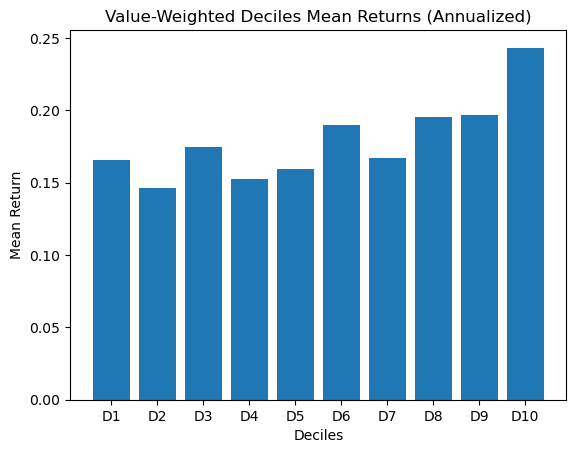

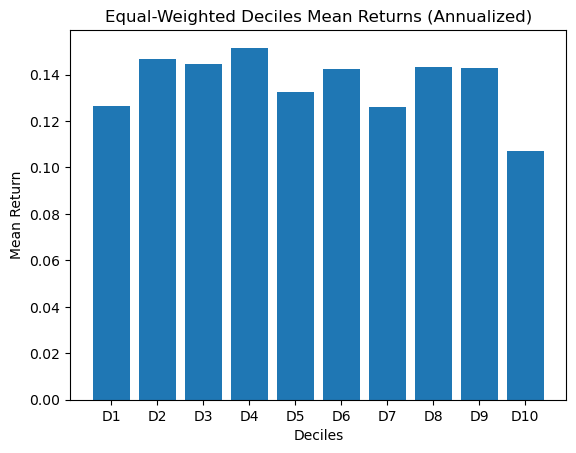

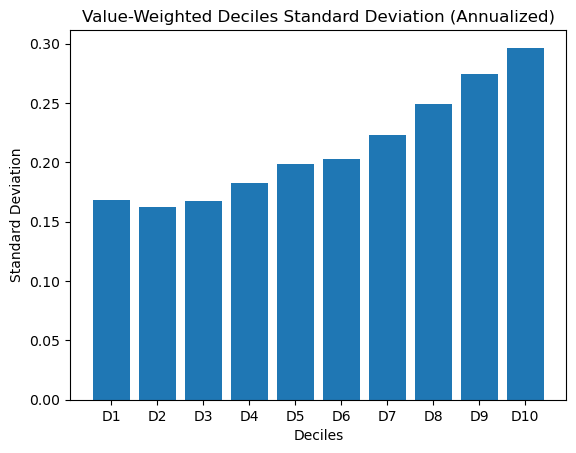

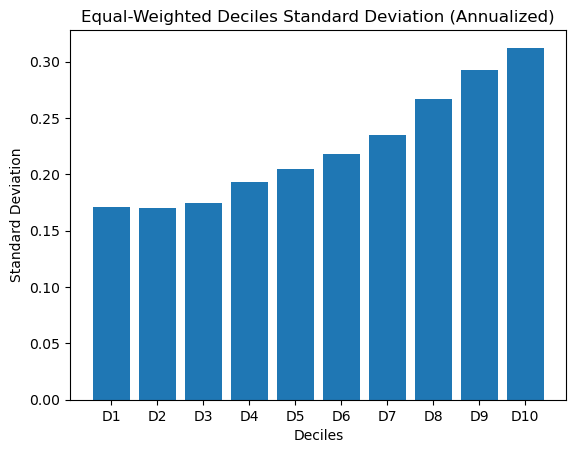

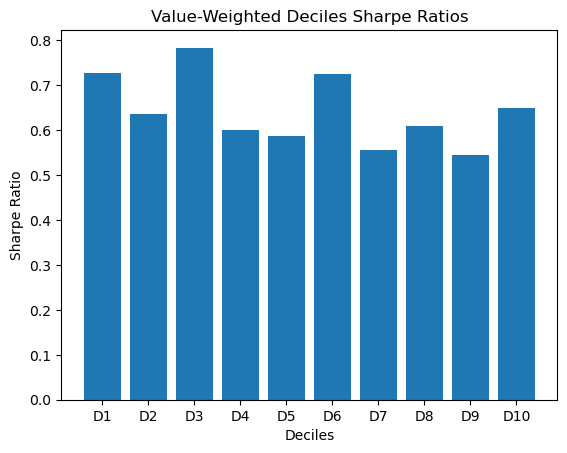

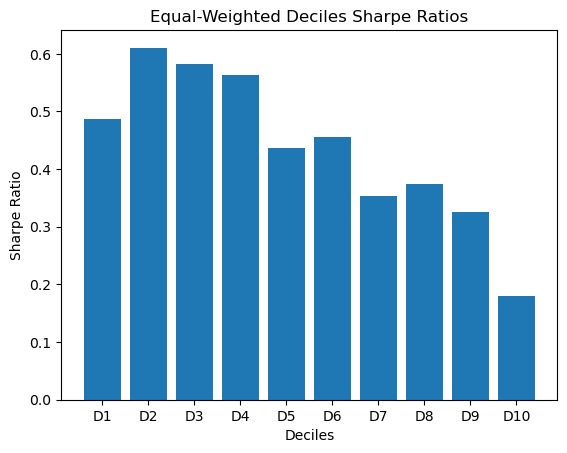

In [24]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# (b)
# 1. Deciles
data['beta_Q'] = data.groupby('date')['beta'].transform(lambda x: pd.qcut(x, 10, labels=False, duplicates='drop'))
# 2. Market Weights within deciles
data['vw_Q'] = data['mcap'] / data.groupby(['date', 'beta_Q'])['mcap'].transform('sum')

# 3. VW Portfolios
data['beta_ret_vw'] = data['vw_Q'] * data['Rn']
ret_vw = data.groupby(['date', 'beta_Q'])['beta_ret_vw'].sum().reset_index()
vw_ret_mean = ret_vw.groupby('beta_Q')['beta_ret_vw'].mean()

# 4. Equal-Weighted portfolios
ret_ew = data.groupby(['date', 'beta_Q'])['Rn'].mean().reset_index()
ew_ret_mean = ret_ew.groupby('beta_Q')['Rn'].mean()

# Calculate standard deviations
vw_ret_std = ret_vw.groupby('beta_Q')['beta_ret_vw'].std()
ew_ret_std = ret_ew.groupby('beta_Q')['Rn'].std()

# Compute the Sharpe Ratios for each decile

# compute the risk-free rate
rf = data.groupby(['date', 'beta_Q'])['rf'].mean().reset_index()

# compute the excess returns
ret_vw['excess'] = ret_vw['beta_ret_vw'] - rf['rf']
ret_ew['excess'] = ret_ew['Rn'] - rf['rf']

# compute the Sharpe Ratios
vw_sharpe = ret_vw.groupby('beta_Q')['excess'].mean() / ret_vw.groupby('beta_Q')['beta_ret_vw'].std()
ew_sharpe = ret_ew.groupby('beta_Q')['excess'].mean() / ret_ew.groupby('beta_Q')['Rn'].std()

# 5. Plot Histograms
deciles = ['D' + str(x) for x in np.arange(1, 11)]

directory = 'Plots/Part3'

#save plots
# Plot VW mean returns
plt.bar(deciles, vw_ret_mean * 12)
plt.title('Value-Weighted Deciles Mean Returns (Annualized)')
plt.xlabel('Deciles')
plt.ylabel('Mean Return')
plt.show()

# Plot EW mean returns
plt.bar(deciles, ew_ret_mean * 12)
plt.title('Equal-Weighted Deciles Mean Returns (Annualized)')
plt.xlabel('Deciles')
plt.ylabel('Mean Return')
plt.show()

# Plot VW standard deviations
plt.bar(deciles, vw_ret_std * np.sqrt(12))
plt.title('Value-Weighted Deciles Standard Deviation (Annualized)')
plt.xlabel('Deciles')
plt.ylabel('Standard Deviation')
plt.show()

# Plot EW standard deviations
plt.bar(deciles, ew_ret_std * np.sqrt(12))
plt.title('Equal-Weighted Deciles Standard Deviation (Annualized)')
plt.xlabel('Deciles')
plt.ylabel('Standard Deviation')
plt.show()

# Plot VW Sharpe Ratios
plt.bar(deciles, vw_sharpe* np.sqrt(12))
plt.title('Value-Weighted Deciles Sharpe Ratios')
plt.xlabel('Deciles')
plt.ylabel('Sharpe Ratio')
plt.show()

# Plot EW Sharpe Ratios
plt.bar(deciles, ew_sharpe* np.sqrt(12))
plt.title('Equal-Weighted Deciles Sharpe Ratios')
plt.xlabel('Deciles')
plt.ylabel('Sharpe Ratio')
plt.show()

TODO
- Question: Summarize our findings. Is the evidence consistent with the CAPM?
- Answer:

#### (c/d) Construct BAB factor

In [25]:
# Weights
data['z'] = data.groupby('date')['beta'].transform(lambda x: x.rank())
data['z_'] = data['z']-data.groupby('date')['z'].transform('mean')
data['k'] = np.abs(data['z_'])
data['k'] = 2/data.groupby('date')['k'].transform('sum')
data['w_H'] = data['k'] * data['z_'] * (data['z_']>0) 
data['w_L'] = -data['k'] * data['z_'] * (data['z_']<0) 

# Weighted returns and beta
data['beta_H'] = data['w_H'] * data['beta']
data['beta_L'] = data['w_L'] * data['beta']
data['R_H'] = data['w_H'] * data['Rn']
data['R_L'] = data['w_L'] * data['Rn']
data['R_H_e'] = data['w_H'] * data['Rn_e']
data['R_L_e'] = data['w_L'] * data['Rn_e']

# Sum up the weighted returns and betas but not the rf
BAB = data.groupby('date')[['R_H','R_L','R_H_e','R_L_e','beta_H','beta_L']].sum().reset_index()
BAB['rf'] = data.groupby('date')['rf'].mean().reset_index()['rf']
# unlevered returns
BAB['BAB2'] = (BAB['R_L_e']/BAB['beta_L']) - ( BAB['R_H_e']/BAB['beta_H'] )


In [26]:
# Merge Market and Risk free Rate
tmp = pd.merge(BAB,data[['date','Rm_e']].drop_duplicates(), on=['date'], how='left')
tmp['alpha'] = 1

# Alpha and Beta
import statsmodels.api as sm
tmp = tmp.dropna()
OLS_Reg = sm.OLS(tmp['BAB2'], tmp[['alpha','Rm_e']]).fit()

# Report the mean,standard deviation, and sharpe ratio and CAPM alpha of the BAB factor
print('Mean:', tmp['BAB2'].mean()*12)
print('Standard Deviation:', tmp['BAB2'].std()*np.sqrt(12))
# Annualize the Sharpe ratio and CAPM alpha
print('Sharpe ratio:', tmp['BAB2'].mean()/tmp['BAB2'].std()*np.sqrt(12))
print('Monthly CAPM Alpha:', OLS_Reg.params['alpha']*12)



Mean: 0.12656087072366015
Standard Deviation: 0.2269499126222955
Sharpe ratio: 0.557659922673294
Monthly CAPM Alpha: 0.08660983073087518


Save factor for our investing strategy

In [27]:
print(len(BAB))
strat = BAB[['date','rf','BAB2']]
strat

682


,date,rf,BAB2
0,1967-01-01,0.003788,0.097196
1,1967-02-01,0.003737,0.037775
2,1967-03-01,0.003385,0.022439
3,1967-04-01,0.002877,0.039181
4,1967-05-01,0.002707,-0.000725
...,...,...,...
677,2023-08-01,0.004463,-0.012170
678,2023-09-01,0.004472,-0.106604
679,2023-10-01,0.004475,-0.098234
680,2023-11-01,0.004455,-0.046456


# 4 Momentum Strategy (Mom)

In [28]:
# Load data
data = pd.read_csv('data_with_industries.csv', sep=',')
data = data[data[industry_column_name] == 1]
# drop last 12 columns
data = data.iloc[:, :-12]
#drop column mcap_l 
data = data.drop(columns=['mcap_l'])
#drop nan in Rn column
data = data.dropna(subset=['Rn'])
# Convert date to datetime
data['date'] = pd.to_datetime(data['date'])
data['date'] = data['date'].dt.to_period('M')
data['date'] = data['date'].dt.to_timestamp()
# Sort the data by permno and date
data = data.sort_values(['permno', 'date']).reset_index(drop=True)
display(data.isna().sum())
data

permno      0
date        0
Rn          0
shrout      0
prc         0
SIC         0
mcap        0
rf        267
Rm          0
const       0
Rn_e      267
Rm_e      267
dtype: int64

,permno,date,Rn,shrout,prc,SIC,mcap,rf,Rm,const,Rn_e,Rm_e
0,10064,1991-11-01,0.003968,9478.0,31.625,3944,299741.75,0.003386,-0.037291,1,0.000582,-0.040677
1,10064,1991-12-01,0.075099,9478.0,34.000,3944,322252.00,0.003097,0.106782,1,0.072002,0.103685
2,10064,1992-01-01,0.058824,9478.0,36.000,3944,341208.00,0.003106,-0.001164,1,0.055718,-0.004270
3,10064,1992-02-01,0.091667,9478.0,39.250,3944,372011.50,0.003208,0.013355,1,0.088459,0.010147
4,10064,1992-03-01,0.124204,9752.0,44.125,3944,430307.00,0.003343,-0.023699,1,0.120861,-0.027042
...,...,...,...,...,...,...,...,...,...,...,...,...
136330,93179,2012-07-01,-0.349650,258926.0,4.650,2015,1204005.90,0.000051,0.010307,1,-0.349701,0.010256
136331,93179,2012-08-01,0.144086,258926.0,5.320,2015,1377486.32,0.000065,0.026317,1,0.144021,0.026252
136332,93179,2012-09-01,-0.039474,258926.0,5.110,2015,1323111.86,0.000034,0.026513,1,-0.039508,0.026479
136333,93179,2012-10-01,0.101761,258999.0,5.630,2015,1458164.37,0.000078,-0.014055,1,0.101683,-0.014133


In [29]:
data['LN_Cret12'] = data.groupby('permno').apply(lambda x: np.log(x.Rn+1).rolling(11, min_periods = 11, closed='left').sum()).values

# shift the LN_Cret12 column by 1
data['LN_Cret12'] = data.groupby('permno')['LN_Cret12'].shift(1)
data.dropna(subset=['LN_Cret12'], inplace=True)

q = 10
data['Momentum'] = data.groupby('date')['LN_Cret12'].transform(lambda x: pd.qcut(x,q,labels=False, duplicates='drop'))
data

,permno,date,Rn,shrout,prc,SIC,mcap,rf,Rm,const,Rn_e,Rm_e,LN_Cret12,Momentum
12,10064,1992-11-01,-0.025000,28474.0,14.625,3944,416432.25,0.002225,0.040181,1,-0.027225,0.037956,0.109490,5
13,10064,1992-12-01,-0.109402,31608.0,13.000,3944,410904.00,0.002437,0.017740,1,-0.111839,0.015303,-0.048621,2
14,10064,1993-01-01,-0.067308,31608.0,12.125,3944,383247.00,0.002386,0.012616,1,-0.069694,0.010230,-0.146352,1
15,10064,1993-02-01,-0.010309,31608.0,12.000,3944,379296.00,0.002267,0.005425,1,-0.012576,0.003158,-0.319373,0
16,10064,1993-03-01,0.095833,31608.0,13.125,3944,414855.00,0.002386,0.025089,1,0.093447,0.022703,-0.476759,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
136330,93179,2012-07-01,-0.349650,258926.0,4.650,2015,1204005.90,0.000051,0.010307,1,-0.349701,0.010256,0.417103,9
136331,93179,2012-08-01,0.144086,258926.0,5.320,2015,1377486.32,0.000065,0.026317,1,0.144021,0.026252,0.398495,8
136332,93179,2012-09-01,-0.039474,258926.0,5.110,2015,1323111.86,0.000034,0.026513,1,-0.039508,0.026479,0.289834,8
136333,93179,2012-10-01,0.101761,258999.0,5.630,2015,1458164.37,0.000078,-0.014055,1,0.101683,-0.014133,0.219859,5


In [30]:
# 2. Market Weights within deciles
data['vw_Q'] = data['mcap']/data.groupby(['date','Momentum'])['mcap'].transform('sum')

# 3. VW Portfolios
data['MOM_ret_vw'] = data['vw_Q']*data['Rn']
ret_vw = data.groupby(['date','Momentum'])['MOM_ret_vw'].sum().reset_index()
vw_ret_mean = ret_vw.groupby('Momentum')['MOM_ret_vw'].mean()

# 4. Equal-Weighted portfolios
ret_ew = data.groupby(['date','Momentum'])['Rn'].mean().reset_index()
ew_ret_mean = ret_ew.groupby('Momentum')['Rn'].mean()

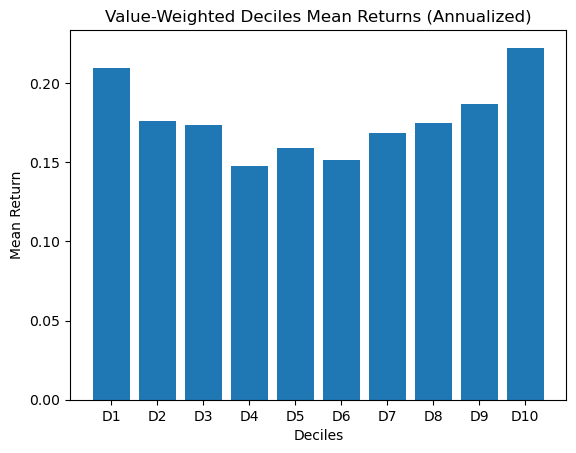

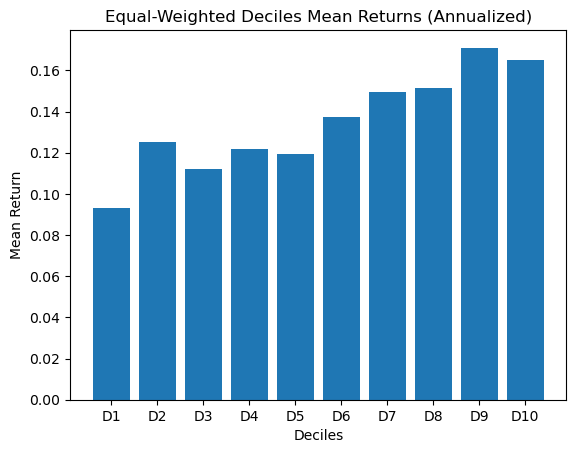

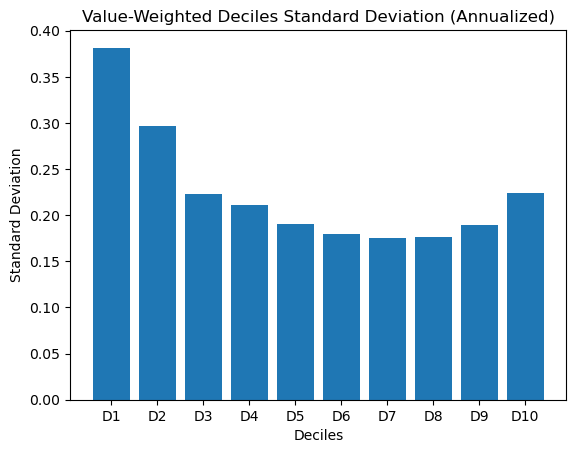

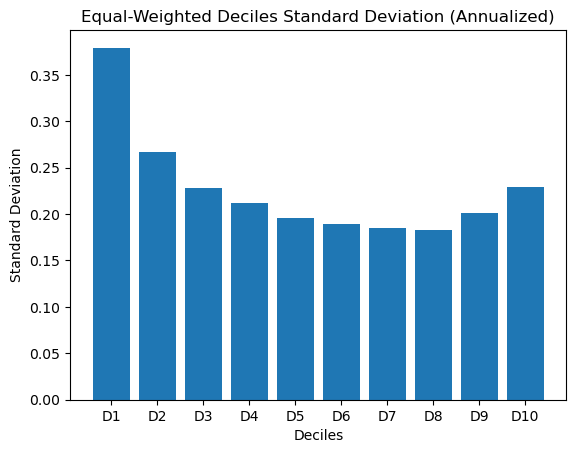

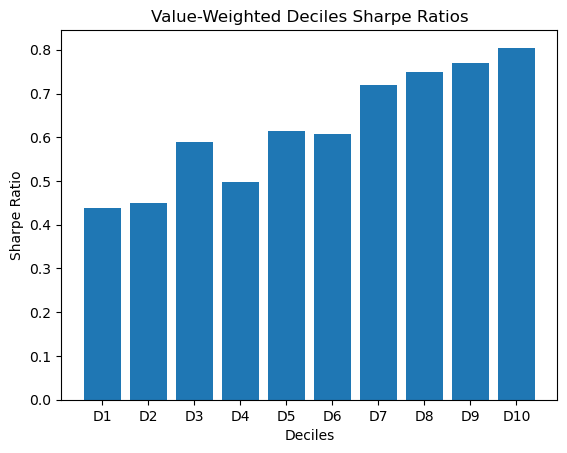

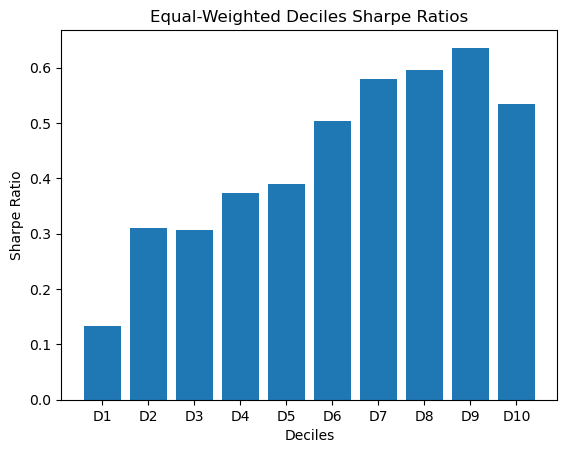

In [31]:
# Calculate standard deviations
vw_ret_std = ret_vw.groupby('Momentum')['MOM_ret_vw'].std()
ew_ret_std = ret_ew.groupby('Momentum')['Rn'].std()

# Calculate Sharpe Ratios

# compute the risk-free rate
rf = data.groupby(['date', 'Momentum'])['rf'].mean().reset_index()

# compute the excess returns
ret_vw['excess'] = ret_vw['MOM_ret_vw'] - rf['rf']
ret_ew['excess'] = ret_ew['Rn'] - rf['rf']

# compute the Sharpe Ratios
vw_sharpe_ratio = ret_vw.groupby('Momentum')['excess'].mean() / vw_ret_std
ew_sharpe_ratio = ret_ew.groupby('Momentum')['excess'].mean() / ew_ret_std


# 5. Plot Histograms
deciles = ['D' + str(x) for x in np.arange(1, 11)]

directory = 'Plots/Part4/'
#save plots
# Plot VW mean returns
plt.bar(deciles, vw_ret_mean * 12)
plt.title('Value-Weighted Deciles Mean Returns (Annualized)')
plt.xlabel('Deciles')
plt.ylabel('Mean Return')
plt.show()

# Plot EW mean returns
plt.bar(deciles, ew_ret_mean * 12)
plt.title('Equal-Weighted Deciles Mean Returns (Annualized)')
plt.xlabel('Deciles')
plt.ylabel('Mean Return')
plt.show()

# Plot VW standard deviations
plt.bar(deciles, vw_ret_std * np.sqrt(12))
plt.title('Value-Weighted Deciles Standard Deviation (Annualized)')
plt.xlabel('Deciles')
plt.ylabel('Standard Deviation')
plt.show()

# Plot EW standard deviations
plt.bar(deciles, ew_ret_std * np.sqrt(12))
plt.title('Equal-Weighted Deciles Standard Deviation (Annualized)')
plt.xlabel('Deciles')
plt.ylabel('Standard Deviation')
plt.show()

# Plot VW Sharpe ratios
plt.bar(deciles, vw_sharpe_ratio * np.sqrt(12))
plt.title('Value-Weighted Deciles Sharpe Ratios')
plt.xlabel('Deciles')
plt.ylabel('Sharpe Ratio')
plt.show()

# Plot EW Sharpe ratios
plt.bar(deciles, ew_sharpe_ratio * np.sqrt(12))
plt.title('Equal-Weighted Deciles Sharpe Ratios')
plt.xlabel('Deciles')
plt.ylabel('Sharpe Ratio')
plt.show()

### Factor creation

#### Equal-Weighted Long-Short Factor Strategy

In [32]:
# 1. Compute the long and short legs of the strategy
ew_long_leg = data[data['Momentum'] >= 7].groupby('date')['Rn'].mean().reset_index()
ew_short_leg = data[data['Momentum'] < 3].groupby('date')['Rn'].mean().reset_index()

# 2. Compute the excess returns
rf = data.groupby(['date', 'Momentum'])['rf'].mean().reset_index()

ew_long_leg['excess'] = ew_long_leg['Rn'] - rf['rf']
ew_short_leg['excess'] = ew_short_leg['Rn'] - rf['rf']

# 3. Compute the mean, excess mean, standard deviation, and Sharpe ratios
long_mean = ew_long_leg['Rn'].mean() * 12
short_mean = ew_short_leg['Rn'].mean() * 12

long_mean_e = ew_long_leg['excess'].mean() * 12
short_mean_e = ew_short_leg['excess'].mean() * 12

long_std = ew_long_leg['Rn'].std() * np.sqrt(12)
short_std = ew_short_leg['Rn'].std() * np.sqrt(12)

long_sharpe_ratio = long_mean_e / long_std
short_sharpe_ratio = short_mean_e / short_std

# Long minus short factor strategy
factor = ew_long_leg.set_index("date") - ew_short_leg.set_index("date")
factor = factor.reset_index()
factor['excess'] = factor['Rn'] - rf['rf']

factor_mean = factor['Rn'].mean() * 12
factor_mean_e = factor['excess'].mean() * 12
factor_std = factor['Rn'].std() * np.sqrt(12)
factor_sharpe_ratio = factor_mean_e / factor_std

# 4. Print the results
print('Long Leg Mean Return:', long_mean)
print('Short Leg Mean Return:', short_mean)
print('Long Leg Standard Deviation:', long_std)
print('Short Leg Standard Deviation:', short_std)
print('Long Leg Sharpe Ratio:', long_sharpe_ratio)
print('Short Leg Sharpe Ratio:', short_sharpe_ratio)
print('Factor Mean Return:', factor_mean)
print('Factor Standard Deviation:', factor_std)
print('Factor Sharpe Ratio:', factor_sharpe_ratio)

Long Leg Mean Return: 0.1622678516807169
Short Leg Mean Return: 0.11071333129682276
Long Leg Standard Deviation: 0.18715202544101742
Short Leg Standard Deviation: 0.26558297911552936
Long Leg Sharpe Ratio: 0.6150628671327014
Short Leg Sharpe Ratio: 0.23852519129453612
Factor Mean Return: 0.051554520383894104
Factor Standard Deviation: 0.19274857783176597
Factor Sharpe Ratio: 0.00991809739306119


In [33]:
import scipy.stats as stats

# Test if the factor strategy has an average return that is statistically significantly different from zero

# 1. Compute the t-statistic
t_stat = factor_mean / (factor_std / np.sqrt(len(factor)))

# 2. Compute the p-value
p_value = 1 - stats.norm.cdf(t_stat)

# 3. Print the results
print('T-Statistic:', t_stat)
print('P-Value:', p_value)

# 4. Check if the p-value is less than 0.05
if p_value < 0.05:
    print('The factor strategy has an average return that is statistically significantly different from zero.')
else:
    print('The factor strategy does not have an average return that is statistically significantly different from zero.')


T-Statistic: 7.116921858231489
P-Value: 5.517808432387028e-13
The factor strategy has an average return that is statistically significantly different from zero.


#### Value-Weighted Long-Short Factor Strategy

In [34]:
#1. Compute the long and short legs of the strategy
vw_long_leg = data[data['Momentum'] >= 7].groupby('date')['MOM_ret_vw'].sum().reset_index()
vw_short_leg = data[data['Momentum'] < 3].groupby('date')['MOM_ret_vw'].sum().reset_index()

# 2. Compute the excess returns
rf = data.groupby(['date', 'Momentum'])['rf'].mean().reset_index()

vw_long_leg['excess'] = vw_long_leg['MOM_ret_vw'] - rf['rf']
vw_short_leg['excess'] = vw_short_leg['MOM_ret_vw'] - rf['rf']

# 3. Compute the mean, excess mean, standard deviation, and Sharpe ratios
long_mean = vw_long_leg['MOM_ret_vw'].mean() * 12
short_mean = vw_short_leg['MOM_ret_vw'].mean() * 12

long_mean_e = vw_long_leg['excess'].mean() * 12
short_mean_e = vw_short_leg['excess'].mean() * 12

long_std = vw_long_leg['MOM_ret_vw'].std() * np.sqrt(12)
short_std = vw_short_leg['MOM_ret_vw'].std() * np.sqrt(12)

long_sharpe_ratio = long_mean_e / long_std
short_sharpe_ratio = short_mean_e / short_std

# Long minus short factor strategy
factor = vw_long_leg.set_index("date") - vw_short_leg.set_index("date")
factor = factor.reset_index()
factor['excess'] = factor['MOM_ret_vw'] - rf['rf']

factor_mean = factor['MOM_ret_vw'].mean() * 12
factor_mean_e = factor['excess'].mean() * 12
factor_std = factor['MOM_ret_vw'].std() * np.sqrt(12)
factor_sharpe_ratio = factor_mean_e / factor_std

# 4. Print the results
print('Long Leg Mean Return:', long_mean)
print('Short Leg Mean Return:', short_mean)
print('Long Leg Standard Deviation:', long_std)
print('Short Leg Standard Deviation:', short_std)
print('Long Leg Sharpe Ratio:', long_sharpe_ratio)
print('Short Leg Sharpe Ratio:', short_sharpe_ratio)
print('Factor Mean Return:', factor_mean)
print('Factor Standard Deviation:', factor_std)
print('Factor Sharpe Ratio:', factor_sharpe_ratio)

Long Leg Mean Return: 0.5840936957775874
Short Leg Mean Return: 0.5590687160218091
Long Leg Standard Deviation: 0.5126887204054732
Short Leg Standard Deviation: 0.7914516514722599
Long Leg Sharpe Ratio: 1.0472872254050214
Short Leg Sharpe Ratio: 0.625908475293788
Factor Mean Return: 0.025024979755778436
Factor Standard Deviation: 0.6796287269566992
Factor Sharpe Ratio: -0.01220413427935181


In [35]:
# Test if the factor strategy has an average return that is statistically significantly different from zero

# 1. Compute the t-statistic
t_stat = factor_mean / (factor_std / np.sqrt(len(factor)))

# 2. Compute the p-value
p_value = 1 - stats.norm.cdf(t_stat)

# 3. Print the results
print('T-Statistic:', t_stat)
print('P-Value:', p_value)

# 4. Check if the p-value is less than 0.05
if p_value < 0.05:
    print('The factor strategy has an average return that is statistically significantly different from zero.')
else:
    print('The factor strategy does not have an average return that is statistically significantly different from zero.')

T-Statistic: 0.979757588875447
P-Value: 0.16360289580044673
The factor strategy does not have an average return that is statistically significantly different from zero.


In [36]:
# Merge factor dataframe with strat dataframe
strat = strat.merge(factor[['date','MOM_ret_vw']], on='date', how='left')

In [37]:
strat

,date,rf,BAB2,MOM_ret_vw
0,1967-01-01,0.003788,0.097196,-0.295926
1,1967-02-01,0.003737,0.037775,-0.007230
2,1967-03-01,0.003385,0.022439,0.109947
3,1967-04-01,0.002877,0.039181,0.011003
4,1967-05-01,0.002707,-0.000725,-0.016754
...,...,...,...,...
677,2023-08-01,0.004463,-0.012170,-0.120180
678,2023-09-01,0.004472,-0.106604,0.045964
679,2023-10-01,0.004475,-0.098234,0.239927
680,2023-11-01,0.004455,-0.046456,0.197517


# 5 Idiosyncratic Volatility Strategy (IV)

In [38]:
data = pd.read_csv('data_with_industries.csv', sep=',')
data = data[data[industry_column_name] == 1]
# drop last 12 columns
data = data.iloc[:, :-12]
data['date'] = pd.to_datetime(data['date'])
data['date'] = data['date'].dt.to_period('M')
data['date'] = data['date'].dt.to_timestamp()
# sort the data by date inside each permno
data = data.sort_values(by=['permno','date']).reset_index(drop=True)

In [39]:
# 0. Remove nans
data = data.dropna(subset=['mcap_l','Rn_e','Rm_e']).copy()

# 2. Estimate Rolling Betas
cov_nm = data.set_index('date').groupby('permno')[['Rn_e','Rm_e']].rolling(60, min_periods=36).cov()
beta_n = (cov_nm.iloc[0::2,1].droplevel(2)/cov_nm.iloc[1::2,1].droplevel(2))
beta_n = beta_n.dropna().reset_index().rename(columns={'Rm_e':'beta'})

# 3. Merge With data
beta_n['date'] = beta_n['date'] + pd.DateOffset(months=1)
data = pd.merge(data, beta_n, on=['date','permno'], how='left')

# get rid of nan values
data = data.dropna(subset=['beta']).copy()

# 4. Remove outliers
data['beta'] = data['beta'].clip(data['beta'].quantile(0.05),data['beta'].quantile(0.95))

In [40]:
data

,permno,date,Rn,shrout,prc,SIC,mcap,mcap_l,rf,Rm,const,Rn_e,Rm_e,beta
36,10064,1994-11-01,-0.076923,34703.0,6.000,3944,208218.000,195204.375,0.004125,-0.037206,1,-0.081048,-0.041331,0.519891
37,10064,1994-12-01,-0.062500,34703.0,5.625,3944,195204.375,164839.250,0.003946,0.012580,1,-0.066446,0.008634,0.572794
38,10064,1995-01-01,-0.155556,34703.0,4.750,3944,164839.250,190866.500,0.004318,0.020353,1,-0.159874,0.016035,0.566193
39,10064,1995-02-01,0.157895,34703.0,5.500,3944,190866.500,177852.875,0.004182,0.039647,1,0.153713,0.035465,0.513508
40,10064,1995-03-01,-0.068182,34703.0,5.125,3944,177852.875,195204.375,0.004812,0.027064,1,-0.072994,0.022252,0.668101
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
135129,93056,2013-05-01,-0.119888,89538.0,9.470,2033,847924.860,1141609.500,0.000013,0.019128,1,-0.119901,0.019115,1.253389
135130,93056,2013-06-01,0.346357,89538.0,12.750,2033,1141609.500,1159568.100,0.000008,-0.015072,1,0.346349,-0.015080,1.242840
135131,93056,2013-07-01,0.011765,89889.0,12.900,2033,1159568.100,1233277.080,0.000008,0.052658,1,0.011757,0.052650,1.113376
135132,93056,2013-08-01,0.063566,89889.0,13.720,2033,1233277.080,1226045.160,0.000008,-0.025750,1,0.063558,-0.025758,1.092528


In [41]:
# 5. Calculate IV:
# Calculate the predicted return
data['predicted_return_e'] = data['beta'] * data['Rm_e']

# Calculate the residuals
data['residuals'] = data['Rn_e'] - data['predicted_return_e']

# Calculate the rolling standard deviation of the residuals
idiosyncratic_volatility = data.set_index('date').groupby('permno')['residuals'].rolling(window=60, min_periods=36).std()

# Reset the index of the idiosyncratic_volatility Series
idiosyncratic_volatility = idiosyncratic_volatility.reset_index()

# Rename the 0 column to 'idiosyncratic_volatility'
idiosyncratic_volatility = idiosyncratic_volatility.rename(columns={"residuals": 'idiosyncratic_volatility'})

# Merge the idiosyncratic_volatility DataFrame with the original data DataFrame
data = pd.merge(data, idiosyncratic_volatility, on=['date', 'permno'], how='left')

# Drop the intermediate columns
data = data.drop(columns=['predicted_return_e', 'residuals'])

# Drop nans in the idiosyncratic_volatility and beta columns
data = data.dropna(subset=['idiosyncratic_volatility'])

# 4. Remove outliers
data['idiosyncratic_volatility'] = data['idiosyncratic_volatility'].clip(data['idiosyncratic_volatility'].quantile(0.05),data['idiosyncratic_volatility'].quantile(0.95))

In [42]:
data

,permno,date,Rn,shrout,prc,SIC,mcap,mcap_l,rf,Rm,const,Rn_e,Rm_e,beta,idiosyncratic_volatility
62,10225,1970-04-01,0.022472,27038.0,34.1250,2111,9.226718e+05,9.226718e+05,0.005427,-0.105318,1,0.017045,-0.110745,0.806189,0.049730
63,10225,1970-05-01,0.015385,27038.0,34.1250,2111,9.226718e+05,9.666085e+05,0.005257,-0.064346,1,0.010128,-0.069603,0.687456,0.049875
64,10225,1970-06-01,0.047619,27038.0,35.7500,2111,9.666085e+05,1.034204e+06,0.004942,-0.051067,1,0.042677,-0.056009,0.652296,0.050686
65,10225,1970-07-01,0.069930,27038.0,38.2500,2111,1.034204e+06,1.068001e+06,0.004913,0.074170,1,0.065017,0.069257,0.604638,0.050090
66,10225,1970-08-01,0.046405,27038.0,39.5000,2111,1.068001e+06,1.020684e+06,0.005091,0.050036,1,0.041314,0.044945,0.618239,0.049457
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
105798,93012,2023-08-01,0.611940,72082.0,0.8100,2099,5.838642e+04,5.622396e+04,0.004463,-0.020605,1,0.607477,-0.025068,0.235515,0.189614
105799,93012,2023-09-01,-0.037037,72082.0,0.7800,2099,5.622396e+04,3.834762e+04,0.004472,-0.047390,1,-0.041509,-0.051862,0.235515,0.189614
105800,93012,2023-10-01,-0.317949,72082.0,0.5320,2099,3.834762e+04,2.522870e+04,0.004475,-0.028867,1,-0.322424,-0.033342,0.235515,0.189614
105801,93012,2023-11-01,-0.342105,72082.0,0.3500,2099,2.522870e+04,3.525531e+04,0.004455,0.092057,1,-0.346560,0.087602,0.235515,0.189614


### Sorting

In [43]:
data['IV_Q'] = data.groupby('date')['idiosyncratic_volatility'].transform(lambda x: pd.qcut(x, 10,labels=False, duplicates='drop'))

# 2. Market Weights within deciles
data['vw_Q'] = data['mcap']/data.groupby(['date','IV_Q'])['mcap'].transform('sum')

# 3. VW Portfolios
data['IV_ret_vw'] = data['vw_Q']*data['Rn']
ret_vw = data.groupby(['date','IV_Q'])['IV_ret_vw'].sum().reset_index()
vw_ret_mean = ret_vw.groupby('IV_Q')['IV_ret_vw'].mean()

# 4. Equal-Weighted portfolios
ret_ew = data.groupby(['date','IV_Q'])['Rn'].mean().reset_index()
ew_ret_mean = ret_ew.groupby('IV_Q')['Rn'].mean()

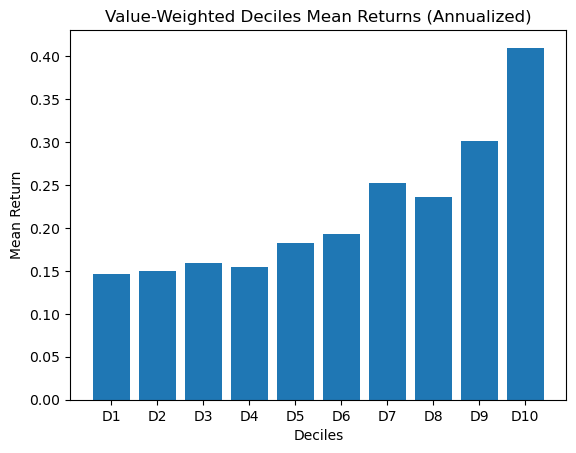

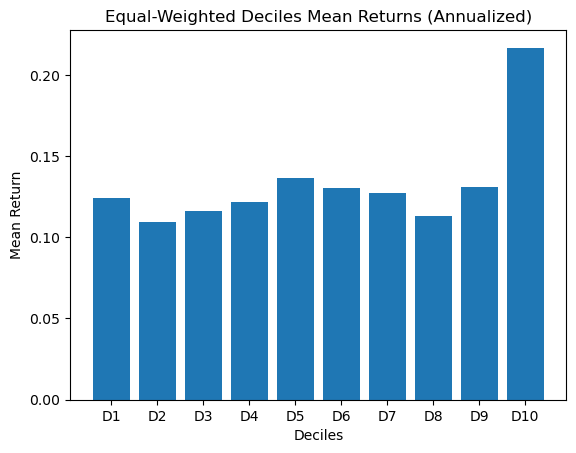

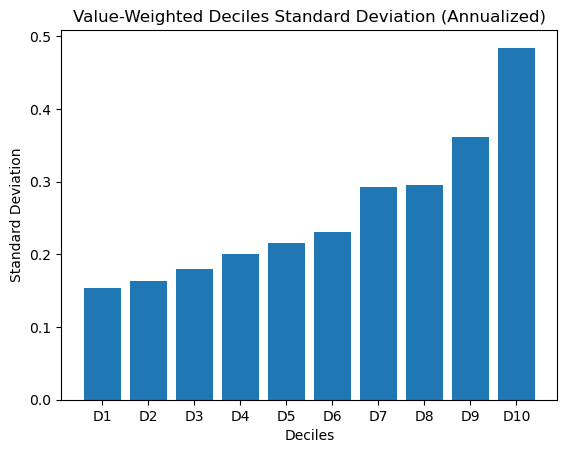

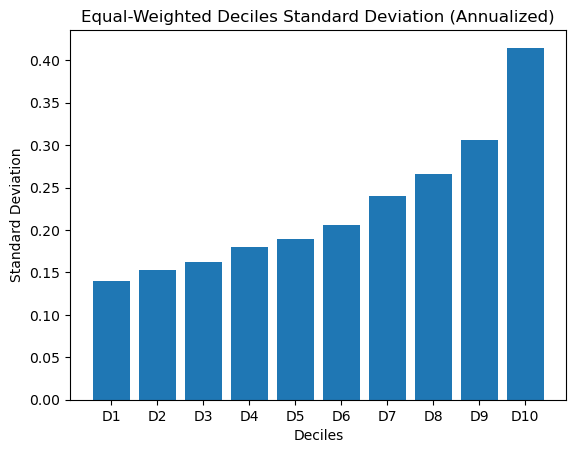

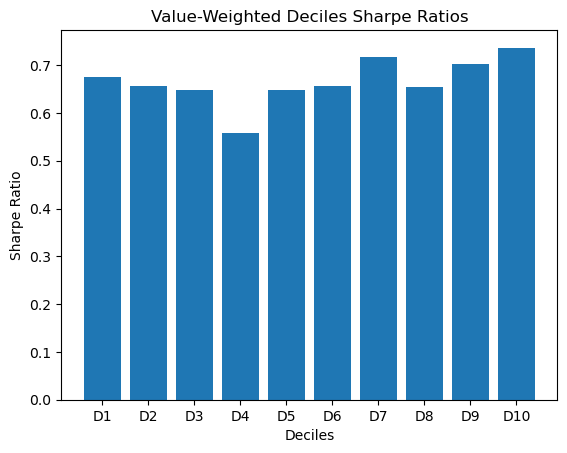

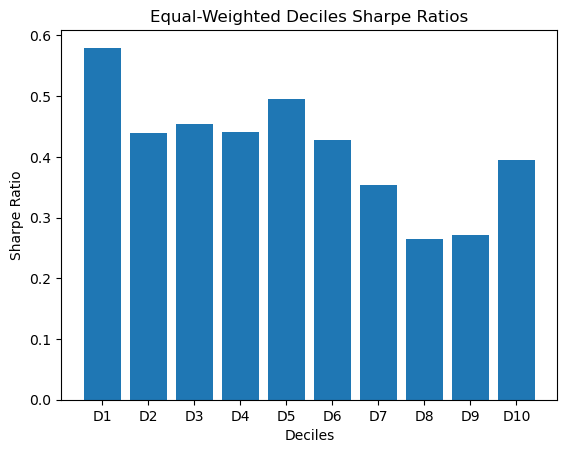

In [44]:
# Calculate standard deviations
vw_ret_std = ret_vw.groupby('IV_Q')['IV_ret_vw'].std()
ew_ret_std = ret_ew.groupby('IV_Q')['Rn'].std()

# Calculate Sharpe Ratios

# compute the risk-free rate
rf = data.groupby(['date', 'IV_Q'])['rf'].mean().reset_index()

# compute the excess returns
ret_vw['excess'] = ret_vw['IV_ret_vw'] - rf['rf']
ret_ew['excess'] = ret_ew['Rn'] - rf['rf']

# compute the Sharpe Ratios
vw_sharpe_ratio = ret_vw.groupby('IV_Q')['excess'].mean() / vw_ret_std
ew_sharpe_ratio = ret_ew.groupby('IV_Q')['excess'].mean() / ew_ret_std


# 5. Plot Histograms
deciles = ['D' + str(x) for x in np.arange(1, 11)]

directory = 'Plots/Part5/'
#save plots
# Plot VW mean returns
plt.bar(deciles, vw_ret_mean * 12)
plt.title('Value-Weighted Deciles Mean Returns (Annualized)')
plt.xlabel('Deciles')
plt.ylabel('Mean Return')
plt.show()

# Plot EW mean returns
plt.bar(deciles, ew_ret_mean * 12)
plt.title('Equal-Weighted Deciles Mean Returns (Annualized)')
plt.xlabel('Deciles')
plt.ylabel('Mean Return')
plt.show()

# Plot VW standard deviations
plt.bar(deciles, vw_ret_std * np.sqrt(12))
plt.title('Value-Weighted Deciles Standard Deviation (Annualized)')
plt.xlabel('Deciles')
plt.ylabel('Standard Deviation')
plt.show()

# Plot EW standard deviations
plt.bar(deciles, ew_ret_std * np.sqrt(12))
plt.title('Equal-Weighted Deciles Standard Deviation (Annualized)')
plt.xlabel('Deciles')
plt.ylabel('Standard Deviation')
plt.show()

# Plot VW Sharpe ratios
plt.bar(deciles, vw_sharpe_ratio * np.sqrt(12))
plt.title('Value-Weighted Deciles Sharpe Ratios')
plt.xlabel('Deciles')
plt.ylabel('Sharpe Ratio')
plt.show()

# Plot EW Sharpe ratios
plt.bar(deciles, ew_sharpe_ratio * np.sqrt(12))
plt.title('Equal-Weighted Deciles Sharpe Ratios')
plt.xlabel('Deciles')
plt.ylabel('Sharpe Ratio')
plt.show()

### Factor creation

Equally weighted factor strategy

In [45]:
# 1. Compute the long and short legs of the strategy
long_leg = data[data['IV_Q'] >= 7].groupby('date')['Rn'].mean().reset_index()
short_leg = data[data['IV_Q'] < 3].groupby('date')['Rn'].mean().reset_index()

# 2. Compute the excess returns
rf = data.groupby(['date', 'IV_Q'])['rf'].mean().reset_index()

long_leg['excess'] = long_leg['Rn'] - rf['rf']
short_leg['excess'] = short_leg['Rn'] - rf['rf']

# 3. Compute the mean, excess mean, standard deviation, and Sharpe ratios
long_mean = long_leg['Rn'].mean() * 12
short_mean = short_leg['Rn'].mean() *12

long_mean_e = long_leg['excess'].mean() *12
short_mean_e = short_leg['excess'].mean() * 12

long_std = long_leg['Rn'].std() * np.sqrt(12)
short_std = short_leg['Rn'].std() * np.sqrt(12)

long_sharpe_ratio = long_mean_e / long_std
short_sharpe_ratio = short_mean_e / short_std

# Long minus short factor strategy
factor = long_leg.set_index("date") - short_leg.set_index("date")
factor = factor.reset_index()
factor['excess'] = factor['Rn'] - rf['rf']

factor_mean = factor['Rn'].mean() * 12
factor_mean_e = factor['excess'].mean() * 12
factor_std = factor['Rn'].std() * np.sqrt(12)
factor_sharpe_ratio = factor_mean_e / factor_std

# 4. Print the results
print('Long Leg Mean Return:', long_mean)
print('Short Leg Mean Return:', short_mean)
print('Long Leg Standard Deviation:', long_std)
print('Short Leg Standard Deviation:', short_std)
print('Long Leg Sharpe Ratio:', long_sharpe_ratio)
print('Short Leg Sharpe Ratio:', short_sharpe_ratio)
print('Factor Mean Return:', factor_mean)
print('Factor Standard Deviation:', factor_std)
print('Factor Sharpe Ratio:', factor_sharpe_ratio)

Long Leg Mean Return: 0.14451315798036676
Short Leg Mean Return: 0.11971617318837874
Long Leg Standard Deviation: 0.2929558985124629
Short Leg Standard Deviation: 0.14048401124833665
Long Leg Sharpe Ratio: 0.3022374342100206
Short Leg Sharpe Ratio: 0.4536593126801615
Factor Mean Return: 0.02497368853742695
Factor Standard Deviation: 0.23195612715730524
Factor Sharpe Ratio: -0.13340880072022976


Save factor for our investing strategy

In [46]:
import scipy.stats as stats

# Test if the factor strategy has an average return that is statistically significantly different from zero

# 1. Compute the t-statistic
t_stat = factor_mean / (factor_std / np.sqrt(len(factor)))

# 2. Compute the p-value
p_value = 1 - stats.norm.cdf(t_stat)

# 3. Print the results
print('T-Statistic:', t_stat)
print('P-Value:', p_value)

# 4. Check if the p-value is less than 0.05
if p_value < 0.05:
    print('The factor strategy has an average return that is statistically significantly different from zero.')
else:
    print('The factor strategy does not have an average return that is statistically significantly different from zero.')


T-Statistic: 2.738602387440367
P-Value: 0.003085047237584404
The factor strategy has an average return that is statistically significantly different from zero.


Value weighted factor strategy

In [47]:
#1. Compute the long and short legs of the strategy
vw_long_leg = data[data['IV_Q'] >= 7].groupby('date')['IV_ret_vw'].sum().reset_index()
vw_short_leg = data[data['IV_Q'] < 3].groupby('date')['IV_ret_vw'].sum().reset_index()

# 2. Compute the excess returns
rf = data.groupby(['date', 'IV_Q'])['rf'].mean().reset_index()

vw_long_leg['excess'] = vw_long_leg['IV_ret_vw'] - rf['rf']
vw_short_leg['excess'] = vw_short_leg['IV_ret_vw'] - rf['rf']

# 3. Compute the mean, excess mean, standard deviation, and Sharpe ratios
long_mean = vw_long_leg['IV_ret_vw'].mean() * 12
short_mean = vw_short_leg['IV_ret_vw'].mean() * 12

long_mean_e = vw_long_leg['excess'].mean() * 12
short_mean_e = vw_short_leg['excess'].mean() * 12

long_std = vw_long_leg['IV_ret_vw'].std() * np.sqrt(12)
short_std = vw_short_leg['IV_ret_vw'].std() * np.sqrt(12)

long_sharpe_ratio = long_mean_e / long_std
short_sharpe_ratio = short_mean_e / short_std

# Long minus short factor strategy
factor = vw_long_leg.set_index("date") - vw_short_leg.set_index("date")
factor = factor.reset_index()
factor['excess'] = factor['IV_ret_vw'] - rf['rf']

factor_mean = factor['IV_ret_vw'].mean()
factor_mean_e = factor['excess'].mean()
factor_std = factor['IV_ret_vw'].std()
factor_sharpe_ratio = factor_mean_e / factor_std

# 4. Print the results
print('Long Leg Mean Return:', long_mean)
print('Short Leg Mean Return:', short_mean)
print('Long Leg Standard Deviation:', long_std)
print('Short Leg Standard Deviation:', short_std)
print('Long Leg Sharpe Ratio:', long_sharpe_ratio)
print('Short Leg Sharpe Ratio:', short_sharpe_ratio)
print('Factor Mean Return:', factor_mean)
print('Factor Standard Deviation:', factor_std)
print('Factor Sharpe Ratio:', factor_sharpe_ratio)

Long Leg Mean Return: 0.8056009144184546
Short Leg Mean Return: 0.4542599949898739
Long Leg Standard Deviation: 0.8474903338053142
Short Leg Standard Deviation: 0.44675951751612875
Long Leg Sharpe Ratio: 0.8845292573135013
Short Leg Sharpe Ratio: 0.8914767031741841
Factor Mean Return: 0.02928731713431658
Factor Standard Deviation: 0.19994983073053807
Factor Sharpe Ratio: 0.1231680330556168


In [48]:
# Test if the factor strategy has an average return that is statistically significantly different from zero

# 1. Compute the t-statistic
t_stat = factor_mean / (factor_std / np.sqrt(len(factor)))

# 2. Compute the p-value
p_value = 1 - stats.norm.cdf(t_stat)

# 3. Print the results
print('T-Statistic:', t_stat)
print('P-Value:', p_value)

# 4. Check if the p-value is less than 0.05
if p_value < 0.05:
    print('The factor strategy has an average return that is statistically significantly different from zero.')
else:
    print('The factor strategy does not have an average return that is statistically significantly different from zero.')

T-Statistic: 3.7257240862739884
P-Value: 9.73776734820575e-05
The factor strategy has an average return that is statistically significantly different from zero.


In [49]:
# Merge factor dataframe with strat dataframe

strat = strat.merge(factor[['date','IV_ret_vw']], on='date', how='left')

# Drop all nans
strat = strat.dropna()

In [50]:
# rename columns to IV and MOM
strat = strat.rename(columns={'IV_ret_vw':'IV','MOM_ret_vw':'MOM'})
strat

,date,rf,BAB2,MOM,IV
35,1970-02-01,0.005253,0.013557,0.037196,0.017470
36,1970-03-01,0.005345,0.053312,-0.064793,0.237003
37,1970-04-01,0.005427,-0.015267,0.184382,-0.382813
38,1970-05-01,0.005257,-0.069630,0.081867,0.068492
39,1970-06-01,0.004942,0.036956,0.376776,-0.189381
...,...,...,...,...,...
677,2023-08-01,0.004463,-0.012170,-0.120180,-0.126489
678,2023-09-01,0.004472,-0.106604,0.045964,-0.071607
679,2023-10-01,0.004475,-0.098234,0.239927,-0.133023
680,2023-11-01,0.004455,-0.046456,0.197517,0.242361


In [51]:
strat.to_csv('strat.csv', sep=';',index=False) # export data

In [52]:
# read csv
strat = pd.read_csv('strat.csv', sep=';')

# 6 Optimal Fund Portfolio Return (STRAT)

In [53]:
# Equal weight strategy
strat['STRAT1'] = (strat['BAB2'] + strat['IV'] + strat['MOM'])/3

# Window size equal to data length
number_of_rows = len(strat)


# Risk-Parity strategy
rolling_vol = strat[['BAB2', 'IV', 'MOM']].rolling(window = 60,min_periods=36).std()
weights = 1 / rolling_vol
# Normalize the weights
weights = weights.div(weights.sum(axis=1), axis=0)
strat['STRAT2'] = (weights['BAB2'] * strat['BAB2'] + weights['IV'] * strat['IV'] + weights['MOM'] * strat['MOM'])

# Mean-variance optimal combination
rolling_mean = strat[['BAB2', 'IV', 'MOM']].rolling(window = 60, min_periods=36).mean()
rolling_cov = strat[['BAB2', 'IV', 'MOM']].rolling(window = 60, min_periods=36).cov()

# w_tan = Cov^(-1) * (mu - Rf * 1) / 1.T * Cov^(-1) * (mu - Rf * 1)

# Iterate over the rolling windows
optimal_weights = []
for i in range(number_of_rows):
    mu = rolling_mean.iloc[i].values
    cov = rolling_cov.loc[rolling_cov.index.get_level_values(0) == i].droplevel(0)
    ones = np.ones(len(mu))
    rf = strat['rf'].iloc[i]
    w_tan = np.linalg.inv(cov).dot((mu - rf * ones)) / (ones.T.dot(np.linalg.inv(cov).dot((mu - rf * ones))))
    optimal_weights.append(w_tan)

optimal_weights = pd.DataFrame(optimal_weights, columns = ['BAB2', 'IV', 'MOM'])
strat['STRAT3'] = (optimal_weights['BAB2'] * strat['BAB2'] + optimal_weights['IV'] * strat['IV'] + optimal_weights['MOM'] * strat['MOM'])

In [54]:
# Calculate the annualized volatility and mean of the STRAT1, STRAT2, and STRAT3 strategies
strat1_mean = strat['STRAT1'].mean() * 12
strat1_std = strat['STRAT1'].std() * np.sqrt(12)
excess_strat1 = strat['STRAT1'] - strat['rf']
strat1_sharpe = excess_strat1.mean() / strat["STRAT1"].std() * np.sqrt(12)

strat2_mean = strat['STRAT2'].mean() * 12
strat2_std = strat['STRAT2'].std() * np.sqrt(12)
excess_strat2 = strat['STRAT2'] - strat['rf']
strat2_sharpe = excess_strat2.mean() / strat["STRAT2"].std() * np.sqrt(12)

strat3_mean = strat['STRAT3'].mean() * 12
strat3_std = strat['STRAT3'].std() * np.sqrt(12)
excess_strat3 = strat['STRAT3'] - strat['rf']
strat3_sharpe = excess_strat3.mean() / strat["STRAT3"].std() * np.sqrt(12)

# Print the results
print('Equal Weighted Strategy:')
print('Mean:', strat1_mean)
print('Standard Deviation:', strat1_std)
print('Sharpe Ratio:', strat1_sharpe)
print("\n")

print('Risk-Parity Strategy:')
print('Mean:', strat2_mean)
print('Standard Deviation:', strat2_std)
print('Sharpe Ratio:', strat2_sharpe)
print("\n")

print('Mean-Variance Optimal Strategy:')
print('Mean:', strat3_mean)
print('Standard Deviation:', strat3_std)
print('Sharpe Ratio:', strat3_sharpe)

Equal Weighted Strategy:
Mean: 0.15392622743327938
Standard Deviation: 0.2572204019454705
Sharpe Ratio: 0.43262940724108534


Risk-Parity Strategy:
Mean: 0.14227911112106553
Standard Deviation: 0.19209634879627782
Sharpe Ratio: 0.5194549080048657


Mean-Variance Optimal Strategy:
Mean: -3.5260647760347315
Standard Deviation: 28.795144554817693
Sharpe Ratio: -0.12392917455824


In [55]:
# Now find c such that the average annual volatility of the fund is 10% in each case
c1 = 0.1 / strat1_std
c2 = 0.1 / strat2_std
c3 = 0.1 / strat3_std

# Calculate the fund returns
strat['fund1'] = strat['rf'] + c1 * strat['STRAT1']
strat['fund2'] = strat['rf'] + c2 * strat['STRAT2']
strat['fund3'] = strat['rf'] + c3 * strat['STRAT3']

# Calculate the annualized volatility and mean of the fund returns
fund1_mean = strat['fund1'].mean() * 12
fund1_std = strat['fund1'].std() * np.sqrt(12)
excess_fund1 = strat['fund1'] - strat['rf']
fund1_sharpe = excess_fund1.mean() / strat["fund1"].std() * np.sqrt(12)

fund2_mean = strat['fund2'].mean() * 12
fund2_std = strat['fund2'].std() * np.sqrt(12)
excess_fund2 = strat['fund2'] - strat['rf']
fund2_sharpe = excess_fund2.mean() / strat["fund2"].std() * np.sqrt(12)

fund3_mean = strat['fund3'].mean() * 12
fund3_std = strat['fund3'].std() * np.sqrt(12)
excess_fund3 = strat['fund3'] - strat['rf']
fund3_sharpe = excess_fund3.mean() / strat["fund3"].std() * np.sqrt(12)

# Print the results

# Print the c
print('c1:', c1)
print('c2:', c2)
print('c3:', c3)
print("\n")

print('Equal Weighted Fund:')
print('Mean:', fund1_mean)
print('Standard Deviation:', fund1_std)
print('Sharpe Ratio:', fund1_sharpe)
print("\n")

print('Risk-Parity Fund:')
print('Mean:', fund2_mean)
print('Standard Deviation:', fund2_std)
print('Sharpe Ratio:', fund2_sharpe)
print("\n")

print('Mean-Variance Optimal Fund:')
print('Mean:', fund3_mean)
print('Standard Deviation:', fund3_std)
print('Sharpe Ratio:', fund3_sharpe)


c1: 0.38877164969674344
c2: 0.5205721015866475
c3: 0.003472807709286845


Equal Weighted Fund:
Mean: 0.10248727078012884
Standard Deviation: 0.1011342719190898
Sharpe Ratio: 0.5917099340835468


Risk-Parity Fund:
Mean: 0.1165602558171977
Standard Deviation: 0.10068688929269053
Sharpe Ratio: 0.7356125152785921


Mean-Variance Optimal Fund:
Mean: 0.030248374991366254
Standard Deviation: 0.10022516924248198
Sharpe Ratio: -0.12217834133093018


In [56]:
filename = f"{industry_column_name}.csv"
strat.drop(columns=['STRAT1','STRAT3','fund1', 'fund3']).to_csv(filename, sep=';', index=False)

# 7 Performance and risk analysis for the Fund strategy